# Load trianing set Tests

This notebook contains code used to load random forest traingin sets

This has all been rolled into other libraries and such so it is mostly for archive purposes. 2020-01-29 rws

In [51]:
from multigrids import TemporalMultiGrid, TemporalGrid, MultiGrid
import numpy as np
import os

from pandas import read_csv, get_dummies, DataFrame, Series
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import datetime
import pickle

data_dir = ('data/V1/')

In [16]:
trainset = TemporalMultiGrid('rf_training_set_v1/rf_traing_set_v1.yml')
trainset.config['start_timestep'] = 1901

In [17]:
tki = TemporalGrid(os.path.join(data_dir, 
    'thermokarst/initiation-regions/ACP/v3-1/PDM-5var/without_predisp/temporal-grid/ia_grid_5var.yml'))


In [36]:
def get_as_ml_features(self, mask = None, train_range = None):
    features = [ [] for g in range(self.config['num_grids']) ]
    if mask is None:
        mask = self.config['mask']
    
    if train_range is None:
        train_range = self.get_range()
    
    for ts in train_range:
        for grid, gnum in self.config['grid_name_map'].items():
#             print(grid, '\t',gnum, '\t',self[grid, ts][mask].shape, '\t', self[grid, ts][mask])

            features[gnum] += list(self[grid, ts][mask])

        
    return np.array(features)



def get_data_subsample(features, labels, percent=.50):
    """return a random subsample of data set
    
    using a “discrete uniform” distribution
    
    Parameters
    ----------
    features: np.array [n_features, n_samples]
        the features array
    labels: np.array [n_samples]
    percent: float [0, 1]
        percent of data to keep
        
    Returns 
    -------
    np.array[n_features, n_samples * percent]
        randomly subsampled feature array 
    np.array[n_features, n_samples * percent]
        randomly subsampled lable array using same 
        index as sampling feature array
    """
    _max = features.shape[1]
    keep = int(_max * percent)
    idx = np.random.randint(_max, size=keep)
    return features.T[idx].T, labels[idx]

def save_rf_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model,f)
        
def show2 (data, title, save =False):
    plt.matshow(data, vmin=-50, vmax=50, cmap='coolwarm')
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    if save:
        plt.savefig( title + '.png')



In [19]:
features = get_as_ml_features(trainset, trainset.config['mask'], range(1902, 2016))

flabels = ['' for g in range(trainset.config['num_grids']) ]
for grid, gnum in trainset.config['grid_name_map'].items():
    flabels[gnum] = grid

/Users/rwspicer/miniconda3/envs/atm-env3/lib/python3.7/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)


In [22]:
labels = tki.get_as_ml_features(None, trainset.config['mask'], range(1902, 2016))

In [23]:
ss_f, ss_l = get_data_subsample(features, labels)

In [28]:
grid_names = ['fdd', 'tdd', 'tdd+1', 'ewp', 'fwp', 'sp', 'lsp', 'sp+1', 'lat', 'long','aspect','slope', 'elev' ]


ss_sample = MultiGrid(1, 17156088, 14, grid_names=grid_names+['tki'])
for idx, grid in enumerate(grid_names):
    ss_sample[grid][:] = ss_f[idx]
#     print(idx,grid)

ss_sample['tki'] = ss_l

In [31]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42, max_leaf_nodes=1000, verbose=2, n_jobs=4)
rf.fit(ss_f.T, ss_l)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 14.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=1000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [32]:
fid = {}
for i, v in enumerate(flabels):
    fid[v] = rf.feature_importances_[i]*100
fid

{'fdd': 3.616032349667094,
 'tdd': 4.563259695195035,
 'tdd+1': 10.24894068583505,
 'ewp': 3.314149918658793,
 'fwp': 45.81305448518493,
 'sp': 2.270603379630441,
 'lsp': 4.253986223258793,
 'sp+1': 2.4807161205291086,
 'lat': 11.461967306719858,
 'long': 11.939137226977362,
 'aspect': 0.0,
 'slope': 0.03815260834353606,
 'elev': 0.0}

In [35]:
def test_a_year(model, testdata, ty, mask):
    pf = testdata[ty]
    test_f = []
    for f in pf:
        test_f.append(list(f[mask]))
    test_f = np.array(test_f)
    test_r = model.predict(test_f.T)
    test_map = np.zeros([415,1096]) - np.nan
    test_map[mask]= test_r
    return test_map

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


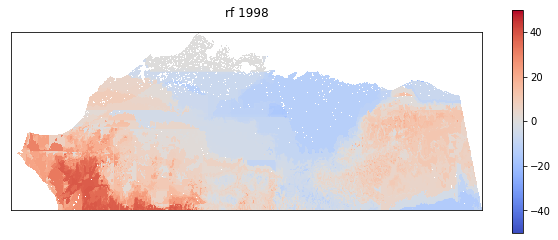

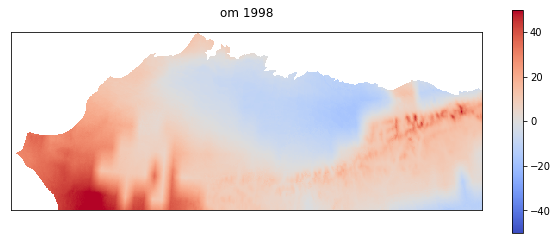

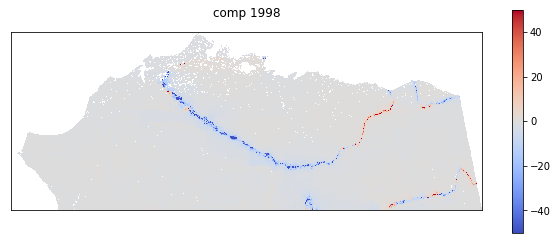

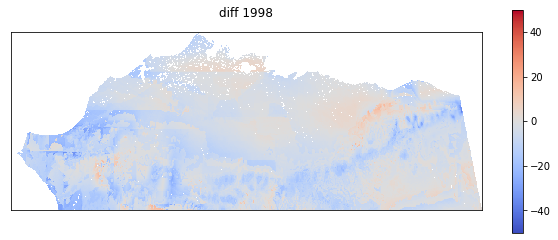

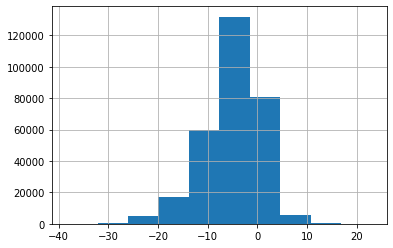

In [61]:
ty = 1998
save = False

test_map = test_a_year(rf, trainset, ty, trainset.config['mask'])
show2(test_map, 'rf ' + str(ty), save)
show2(tki[ty], 'om '+str(ty),save)
show2((test_map - tki[ty])/ np.abs(tki[ty]), 'comp ' +str(ty),save)
show2((test_map - tki[ty]), 'diff ' +str(ty),save)

plt.show()
mask = trainset.config['mask']
diff = (test_map - tki[ty])
ds = Series(diff[mask])
ds.hist()
if save:
    plt.savefig('histogram' + str(ty) + '.png')

In [53]:
os.makedirs('rfm_e10_rs42_mln1000_v2')
save_rf_model(rf, "rfm_e10_rs42_mln1000_v2/rfm_e10_rs42_mln1000_v2.pickle")
ss_sample.save('rfm_e10_rs42_mln1000_v2/training_data.yml')

In [70]:
fid['fwp'] + fid['lat'] + fid['long'] + fid['tdd+1'] + fid['tdd'] #+ fid['lsp']

84.02635939991222

In [66]:
fid

{'fdd': 3.616032349667094,
 'tdd': 4.563259695195035,
 'tdd+1': 10.24894068583505,
 'ewp': 3.314149918658793,
 'fwp': 45.81305448518493,
 'sp': 2.270603379630441,
 'lsp': 4.253986223258793,
 'sp+1': 2.4807161205291086,
 'lat': 11.461967306719858,
 'long': 11.939137226977362,
 'aspect': 0.0,
 'slope': 0.03815260834353606,
 'elev': 0.0}

In [75]:
rf.score(ss_f.T, ss_l)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.1s finished


0.8316985193463993